# 3. Exploratory Data Analysis
_**Authors**: [Boom Devahastin Na Ayudhya](https://linkedin.com/in/boom-devahastin) and [Henry Blais](https://linkedin.com/in/henry-blais)_

## Contents
1. [Import Packages and Data](#Import-Packages-and-Data)
2. [Tweet Analysis: Top Word Counts](#Tweet-Analysis:-Top-Word-Counts)
3. [Expanding Power Outage Keywords](#Expanding-Power-Outage-Keywords)

### Import Packages and Data

In [1]:
# Standard data manipulation libraries
import numpy as np
import pandas as pd

# Load text processing libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import string
import gensim
import en_core_web_sm
import time

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')

C:\Users\Adiwid\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Read clean data
clean_tweets_df = pd.read_csv("./datasets/clean_tweets_20180101-20181231.csv")

### Tweet Analysis: Top Word Counts
(_This section was completed by Boom Devahastin Na Ayudhya_)

Here we examine what the most used words in Tweets about power outages are. We'll begin with writing a helper function that makes use of CountVectorizer to help us get a word count after removing stopwords and punctuation.

In [3]:
# Function to get all words
def all_words(tweet_df):
    
    # Turn tweet into appended list
    tweet_docs = list(clean_tweets_df['text'])    
#     text_docs=[]
#     for tweet in clean_tweets_df['text']:
#         text_docs.append(tweet)
        
    processable_tweets = []
    counter = 0
    nlp = en_core_web_sm.load()
    puncs = string.punctuation
        
    for doc in tweet_docs:
        # Log progress
        counter += 1
        if (counter % 50 == 0) | (counter == len(tweet_docs)):
            print("We have processed %d out of %d tweets." % (counter, len(tweet_docs)))
        
        # Turn off default spacy models
        doc = nlp(doc, disable=['parser', 'ner']) # disabling default models of spacy
        
        # Use list comprehension to tokenize, lemmatize, convert to lower case, and eliminate spacing
        tokens = [token.lemma_.lower().strip() for token in doc if token.lemma_ != '-PRON-']
        
        # Eliminate stopwords and punctuation, but keep URL strings as one "word" (i.e. don't split out http or www)
        tokens = [token for token in tokens if ((token not in stopwords.words('english')) and (token not in puncs))]
        
        # Reconstruct tweet text
        cleaner_tweet = ' '.join(tokens) 
        
        # Append clean title to text list
        processable_tweets.append(cleaner_tweet)  #Appending clean titles to texts list
    
    return pd.Series(processable_tweets)   #Returning texts list as pd Series

In [4]:
# Apply function to get all words (takes around 15 minutes to run for 954 tweets)
processable_tweets = all_words(clean_tweets_df)
processable_tweets = ' '.join(processable_tweets).split()

We have processed 50 out of 954 tweets.
We have processed 100 out of 954 tweets.
We have processed 150 out of 954 tweets.
We have processed 200 out of 954 tweets.
We have processed 250 out of 954 tweets.
We have processed 300 out of 954 tweets.
We have processed 350 out of 954 tweets.
We have processed 400 out of 954 tweets.
We have processed 450 out of 954 tweets.
We have processed 500 out of 954 tweets.
We have processed 550 out of 954 tweets.
We have processed 600 out of 954 tweets.
We have processed 650 out of 954 tweets.
We have processed 700 out of 954 tweets.
We have processed 750 out of 954 tweets.
We have processed 800 out of 954 tweets.
We have processed 850 out of 954 tweets.
We have processed 900 out of 954 tweets.
We have processed 950 out of 954 tweets.
We have processed 954 out of 954 tweets.


In [5]:
# Extract into data frame
common_words = pd.DataFrame(columns=["Top Words", "Frequency"])
cntr = Counter(processable_tweets)
common_words['Top Words'] = [word[0] for word in cntr.most_common(30)]
common_words['Frequency'] = [word[1] for word in cntr.most_common(30)]

In [6]:
# Drop odd case with ellipses
common_words.drop(common_words[common_words["Top Words"].isin(["...", "…"])].index, axis=0, inplace=True)
common_words.head(10)

,Top Words,Frequency
0,power,1080
1,outage,983
3,area,91
5,see,77
6,due,76
7,cause,74
8,get,71
9,light,71
10,go,60
11,report,59


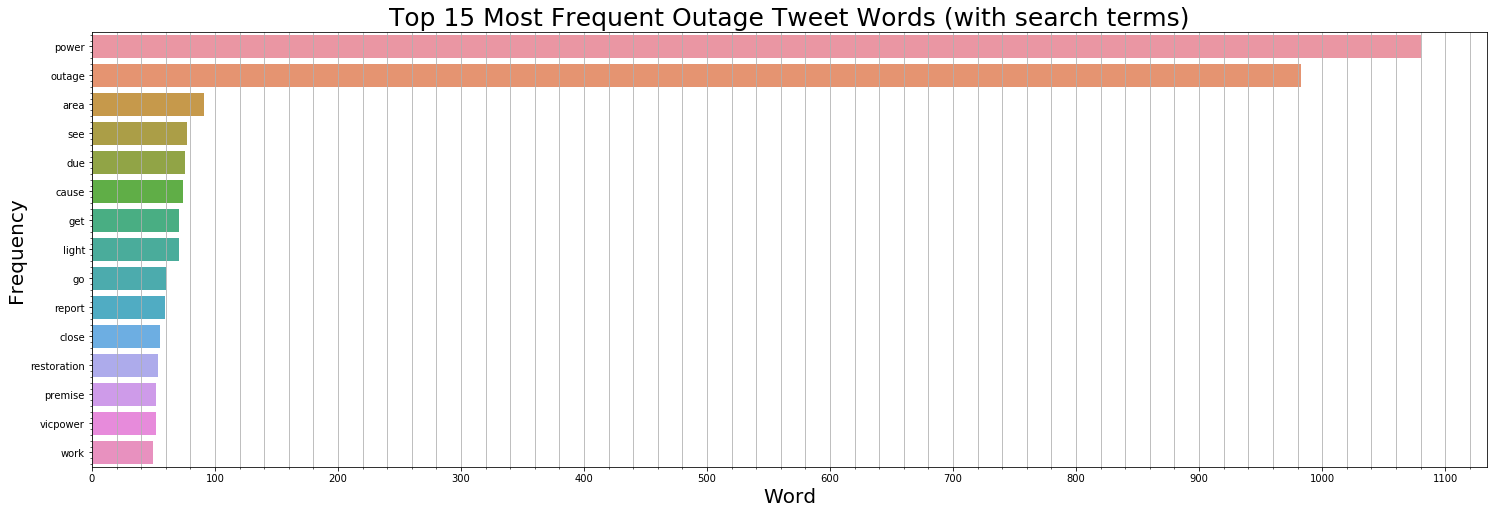

In [39]:
# Plot
fig = plt.figure(figsize=(25,8))
sns.barplot(x=common_words["Frequency"][0:15], y=common_words["Top Words"][0:15])
plt.title('Top 15 Most Frequent Outage Tweet Words (with search terms)', size=25)
plt.xticks(np.arange(0, 1101, 100))
plt.minorticks_on()
plt.grid(which='both', axis='x')
plt.xlabel('Word', size = 20)
plt.ylabel('Frequency', size = 20)
plt.show()

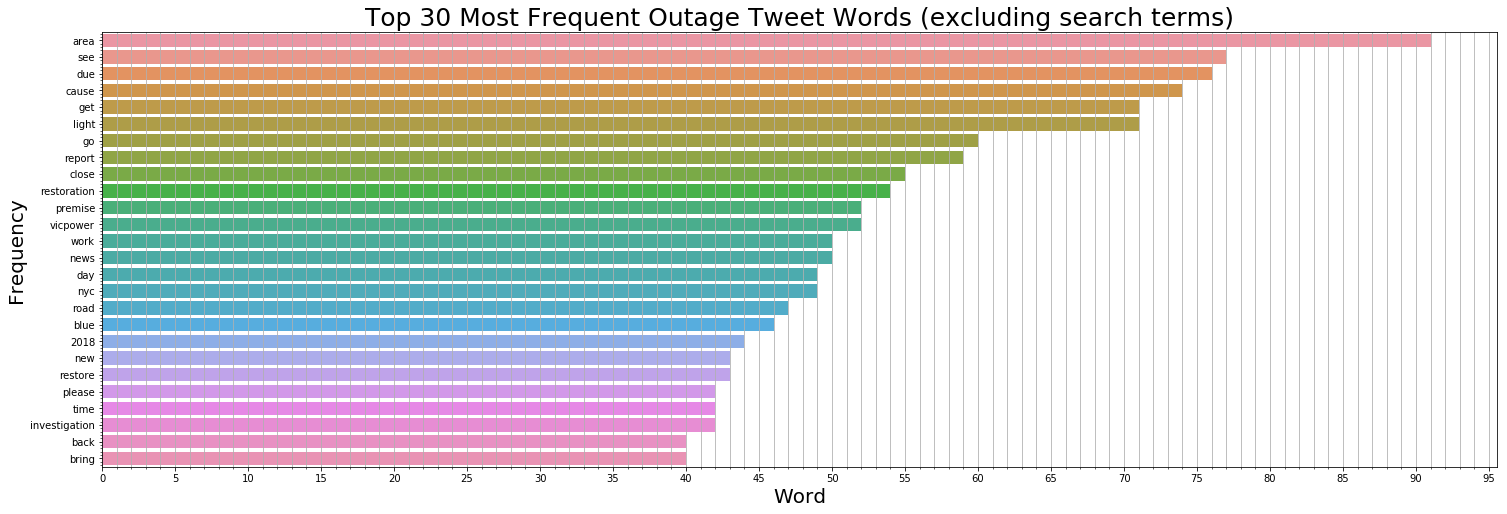

In [34]:
# Plot
fig = plt.figure(figsize=(25,8))
sns.barplot(x=common_words["Frequency"][2:32], y=common_words["Top Words"][2:32])
plt.title('Top 30 Most Frequent Outage Tweet Words (excluding search terms)', size=25)
plt.xticks(np.arange(0, max(common_words["Frequency"][2:32])+6, 5))
plt.minorticks_on()
plt.grid(which='both', axis='x')
plt.xlabel('Word', size = 20)
plt.ylabel('Frequency', size = 20)
plt.show()

Based on the whole body of Tweets about power outages, it is unsurprising the top words are "power" and "outage" since after all, these were included in the search query. Interestingly, Twitter users do not seem to be as fond of the word "blackout".

Besides the search terms, most of the other frequently occuring words (e.g. area, see, due, cause, get, go) are rather "neutral" terms that are not extremely helpful when it comes to differentiating between serious electrical outages vs. non-serious / non-electrical outages.

However, "light" (or lights) is certainly a good synonym for electrical power outage. On the other hand, some revealing non-electrical terms are "vicpower" (a baseball term). We will need to take a closer peak into the context of some of these seemingly random terms like "blue" and "premise".

### Expanding Power Outage Keywords
(_This section was completed by Henry Blais_)

#### Rationale
As you are by now aware, our Twitter scraping function was designed to seek out keywords which we though were relevant to power outages. This prefiltering feature was very helpful for cutting through the overwhelming volume of tweets that are posted in the United States each day, and we believed it would increse the proportion of Tweets from blackout zones in our data.  

In the current version of our scraping function, data is drawn from Twitter on a very limited number of keywords.  Ideally, our keyword vocabulary would be much more expansive, and it would be even better if those keywords were chosen from a corpus of confirmed tweets written from actual blackout events.  

Unfortunately, isolating blackouts based on Twitter data proved very challenging.  Without independantly confirmed locations for our Tweets, we have not been able to implement the improved keyword selection that we originally envisioned. Nevertheless, we believe that improved keywords are imperative to any future rollout of this project.  In this notebook, we will lay out the theory and practice that we believe are best for expanding and enriching the keyword vocabulary.

#### Step 1: Explore body of words which we can prove are related to power outages.
To that end: we will use `gensim` and a corpus of Wikipedia articles that we are repurposing here from some earlier classwork.  Our goal is to expand the keywords by disambiguating from words we have chosen that relate to blackouts. This should return a body of words that we may not have even considered.

In [40]:
# Wiki text-data: takes ~ 3 minutes to load:
t0 = time.time()
model = gensim.models.KeyedVectors.load_word2vec_format('../lexvec.enwiki+newscrawl.300d.W.pos.vectors.gz')
print(time.time() - t0)

In [41]:
# Root list of words
words = ['blackout','power','outage','electric','electricity','electrical','transformer','watt','wattage','arc',
         'circuit','breaker','cable','fault','conductor','fuse','riser','insulator','meter',
         'interruption','maintenance','relay','grid','severe','weather','storm','substation','surge','switch',
         'switchyard','station','transmission','system','lines','line','frequency','voltage']

#### Step 2: Construct dictionary of new terms, organized by parent term

In [42]:
# Create list of new terms organized by root word
bank = []
for word in words:
    arr = pd.DataFrame(model.most_similar(word,topn=20),columns=['word','val'])
    arr = arr[arr['val']>.39]
    for i in arr.word:
        bank.append(i)

# Add original terms to list
for word in words:
    bank.append(word)

# View new bank of words
# print(bank)

#### Next Steps
We now have a working dictionary of far more potential keywords. In doing so, we've achieved the desired outcome: Tweets could just as easily be scraped from this larger body of keywords as they were from the smaller group we used to generate this new list.  

An externality of generating these new keywords is that some of these keywords are clearly "off-theme". While "electrical (a term we disambiguated from above) is concievably desirable as a keyword, the terms we generated from it clearly are not. These terms are all very technical and are unlikely to appear in a Tweet pertaining to a blackout.

With this, we can now begin to refine our keywords based on what does or does not appear to work. Whatever keywords that we choose to keep at this stage, the next and final stage in our keyword refinement would depend on having a body of confirmed Tweets from actual blackouts. If we had that data, we would now proceed to CountVectorize these Tweets and perform term frequency analysis on that corpus, thereby helping us filter out the useful keywords we gathered from less useful ones.